In [1]:
cd /content/drive/MyDrive/object-detection/mnist

/content/drive/MyDrive/object-detection/mnist


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path as p
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train: numpy array, shape [60k, 28, 28], value =[0, 255](int)
#x_test: 10k samples

11501568/11490434 [==============================] - 1s 0us/step


# utils

In [3]:
# general utils
import matplotlib.pyplot as plt
from pathlib import Path as p
import pickle

def plot_and_save(a, file_path=''):
    fig, ax = plt.subplots()
    ax.plot(a)
    if file_path:    
        fig.savefig(file_path)
    plt.close(fig)

def folder(path):
    path.mkdir(exist_ok=True, parents=True)
    return path

def pickle_save(x, file):
    with open(file, 'wb') as f:
        pickle.dump(x, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()
    
def pickle_load(file):
    with open(file, 'rb') as f:
        x = pickle.load(f)
    f.close()
    return x

In [5]:
# image augmentation utils
def find_bbox(img):
    a = np.where(img != 0)
    bbox = np.min(a[0]), np.max(a[0]), np.min(a[1]), np.max(a[1])
    return bbox

def crop_to_bbox(img):
    '''Crop image to bounding box size'''
    a = np.where(img != 0)
    xmin, xmax, ymin, ymax = np.min(a[1]), np.max(a[1]), np.min(a[0]), np.max(a[0])
    return np.copy(img[ymin:ymax, xmin:xmax])


def place_in_canvas(canvas, img, i, j):
    mask = img> 0
    canvas[i:i + img.shape[0], j:j + img.shape[1]][mask] = img[mask]

def apply_scaling(img, size=None):
    fx = 2 ** (np.random.sample())
    fy = 2 ** (np.random.sample())
    if size is not None:
        x, y = size
        return cv2.resize(np.copy(img), size, interpolation=cv2.INTER_CUBIC)
    return cv2.resize(np.copy(img), None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)


# train data generation

In [6]:
#output: an np array size [h,w] containing several images in x_train

h, w = 32, 32
n_generate = 16000
n_singles = len(x_train)

k = 0
images = []    #size [n, h,w]
boxes = [] #size [n, n_object, 4] (n_object is different for each sample)
labels = [] #[n, n_object]
for idx in tqdm(range(n_generate)):
    canvas = np.zeros((h, w), dtype=np.uint8) #each canvas is an image in the object detection dataset
    boxes_tmp = []
    labels_tmp = []

    for i in range(0, h, 25): #25 because it produces good spacing between digits in the same image. This is experimented.
        for j in range(0, w, 25):
            if k == 0:
                permuted_idx = np.random.permutation(range(n_singles))
                x_train_permuted = x_train[permuted_idx]
                y_train_permuted = y_train[permuted_idx]
            
            yes = np.random.rand()
            if yes <= 0.8:
                #add a singleton image to the canvas
                img = x_train_permuted[k]
                img = apply_scaling(img, size=(np.random.randint(15, 28), np.random.randint(15, 28)))
                img = crop_to_bbox(img)
                #topleft coord
                tl_i = i + np.random.randint(0, 5) 
                tl_j = j + np.random.randint(0, 5)
                if tl_i + img.shape[0] >= h:
                    tl_i = h - 1 - img.shape[0]
                if tl_j + img.shape[1] >= w:
                    tl_j = w - 1 - img.shape[1]

                place_in_canvas(canvas, img, tl_i, tl_j)

                boxes_tmp.append([tl_i, tl_j, tl_i+img.shape[0], tl_j+img.shape[1]])  
                labels_tmp.append(y_train_permuted[k])
                k = (k+1) % n_singles

    if len(boxes_tmp) == 0: #if the canvas is still empty, add a digit to it at random location
        img = x_train_permuted[k]
        img = apply_scaling(img, size=(np.random.randint(15, 28), np.random.randint(15, 28)))
        img = crop_to_bbox(img)
        tl_i = np.random.randint(0, h) 
        tl_j = np.random.randint(0, w)
        if tl_i + img.shape[0] >= h:
            tl_i = h - 1 - img.shape[0]
        if tl_j + img.shape[1] >= w:
            tl_j = w - 1 - img.shape[1]

        place_in_canvas(canvas, img, tl_i, tl_j)

        boxes_tmp.append([tl_i, tl_j, tl_i+img.shape[0], tl_j+img.shape[1]])  
        labels_tmp.append(y_train_permuted[k])
        k = (k+1) % n_singles

    images.append(canvas)
    boxes.append(boxes_tmp)
    labels.append(labels_tmp)
assert 0 not in list(map(len, boxes))

100%|██████████| 16000/16000 [00:04<00:00, 3652.16it/s]


In [ ]:
pickle_save((images, boxes, labels), p.cwd()/'data/train.pkl')

# test data generation

In [7]:
#output: an np array size [h,w] containing several images in x_train

h, w = 32, 32
n_generate = 2500
n_singles = len(x_test)

k = 0
images = []    #size [n, h,w]
boxes = [] #size [n, n_object, 4] (n_object is different for each sample)
labels = [] #[n, n_object]
for idx in tqdm(range(n_generate)):
    canvas = np.zeros((h, w), dtype=np.uint8)
    boxes_tmp = []
    labels_tmp = []

    for i in range(0, h, 25): #25 because it produces good spacing between digits in the same image
        for j in range(0, w, 25):
            if k == 0:
                permuted_idx = np.random.permutation(range(n_singles))
                x_test_permuted = x_test[permuted_idx]
                y_test_permuted = y_test[permuted_idx]
            
            yes = np.random.rand()
            if yes <= 0.8:
                img = x_test_permuted[k]
                img = apply_scaling(img, size=(np.random.randint(15, 28), np.random.randint(15, 28)))
                img = crop_to_bbox(img)
                #topleft coord
                tl_i = i + np.random.randint(0, 5) 
                tl_j = j + np.random.randint(0, 5)
                if tl_i + img.shape[0] >= h:
                    tl_i = h - 1 - img.shape[0]
                if tl_j + img.shape[1] >= w:
                    tl_j = w - 1 - img.shape[1]

                place_in_canvas(canvas, img, tl_i, tl_j)

                boxes_tmp.append([tl_i, tl_j, tl_i+img.shape[0], tl_j+img.shape[1]])  
                labels_tmp.append(y_test_permuted[k])
                k = (k+1) % n_singles

    if len(boxes_tmp) == 0: #if the canvas is still empty, add a digit to it at random location
        img = x_test_permuted[k]
        img = apply_scaling(img, size=(np.random.randint(15, 28), np.random.randint(15, 28)))
        img = crop_to_bbox(img)
        tl_i = np.random.randint(0, h) 
        tl_j = np.random.randint(0, w)
        if tl_i + img.shape[0] >= h:
            tl_i = h - 1 - img.shape[0]
        if tl_j + img.shape[1] >= w:
            tl_j = w - 1 - img.shape[1]

        place_in_canvas(canvas, img, tl_i, tl_j)

        boxes_tmp.append([tl_i, tl_j, tl_i+img.shape[0], tl_j+img.shape[1]])  
        labels_tmp.append(y_test_permuted[k])
        k = (k+1) % n_singles

    images.append(canvas)
    boxes.append(boxes_tmp)
    labels.append(labels_tmp)
assert 0 not in list(map(len, boxes))

100%|██████████| 2500/2500 [00:00<00:00, 3867.01it/s]


In [ ]:
pickle_save((images, boxes, labels), p.cwd()/'data/test.pkl')

# Visualization

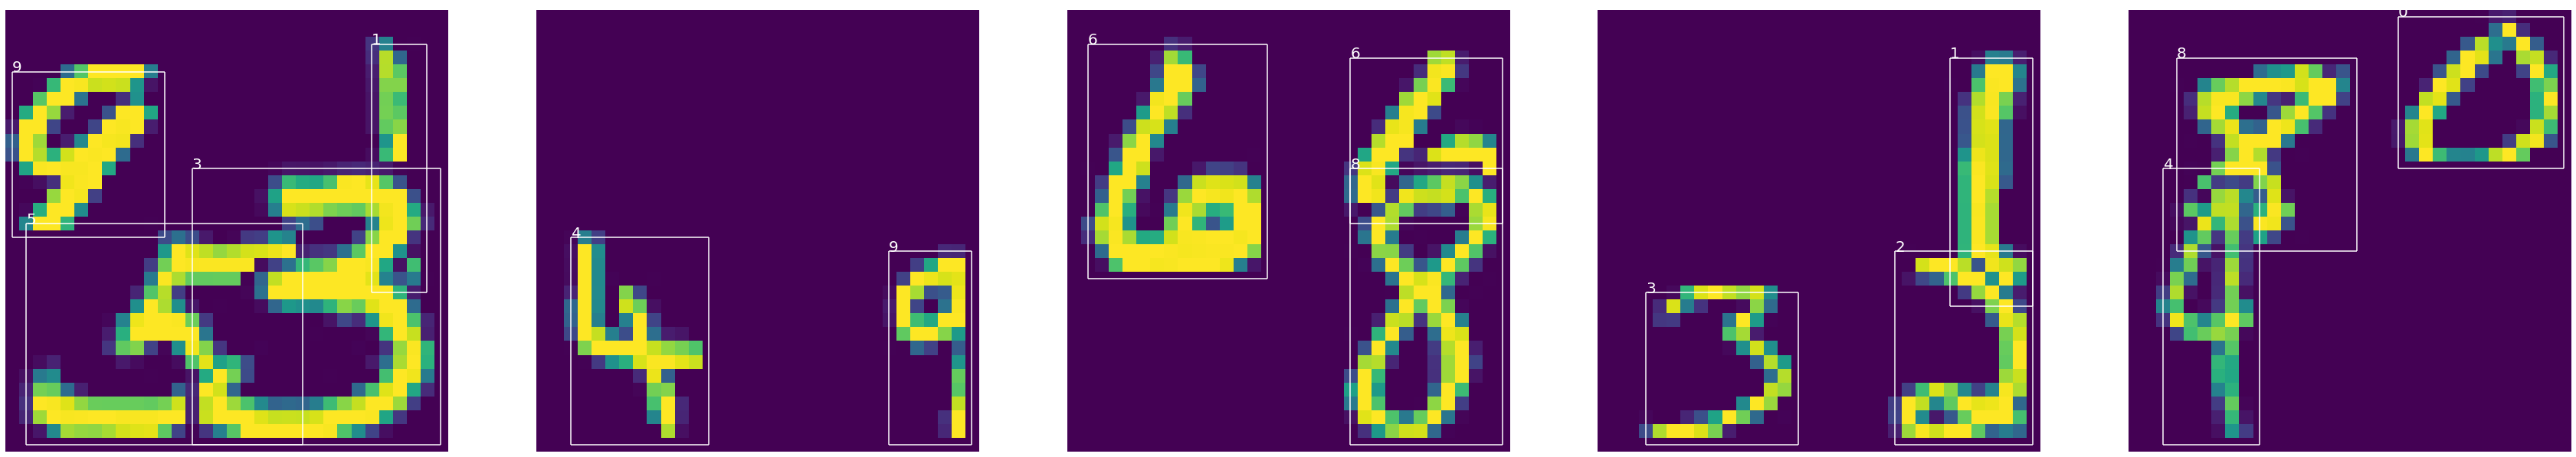

In [14]:
# show some samples
import utils
import torch

n = 5
#prepare image, box, label to fit into function imshow_with_bbox. This is also done in the class MyDataset
img = torch.tensor(images[:n]).unsqueeze(1)
b = [torch.tensor(boxes[i], dtype=torch.float)/h for i in range(n)]
l = [torch.tensor(labels[i]) for i in range(n)]

#imshow
_ = utils.imshow_with_bbox(img, b, l)

In [16]:
# the form of raw boxes
boxes[:5]

[[[4, 0, 16, 11], [2, 26, 20, 30], [15, 1, 31, 21], [11, 13, 31, 31]],
 [[16, 2, 31, 12], [17, 25, 31, 31]],
 [[2, 1, 19, 14], [3, 20, 15, 31], [11, 20, 31, 31]],
 [[3, 25, 21, 31], [20, 3, 31, 14], [17, 21, 31, 31]],
 [[3, 3, 17, 16], [0, 19, 11, 31], [11, 2, 31, 9]]]

In [15]:
# the form of raw labels 
labels[:5]

[[9, 1, 5, 3], [4, 9], [6, 6, 8], [1, 3, 2], [8, 0, 4]]